In [1]:
%matplotlib inline
try:
    import cPickle as pickle
except:
    import pickle
import json
import math
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import pywt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from collections import Counter
import random

In [2]:
def SaveDataFrame(df,picklefile):
    pickle.dump(df,open(picklefile,'w+'))
def LoadDataFrame(picklefile):
    superdf = pickle.load(open(picklefile))
    return superdf
def ObtainSessionData(df,user,session,date):
    return df[df.apply(lambda x:x['User'] == user and x['Session'] == session and x['Day'] == date,axis=1)]

In [3]:
def distance_on_unit_sphere(lat1, long1, lat2=48.787980, long2=11.381053):
        # Convert latitude and longitude to 
        # spherical coordinates in radians.
        #if np.isnan(lat1) or np.isnan(long1) or np.isnan(lat2) or np.isnan(long2):
        #   return 10**6
        degrees_to_radians = math.pi/180.0
        # phi = 90 - latitude
        phi1 = lat1*degrees_to_radians
        phi2 = lat2*degrees_to_radians
        # theta = longitude
        theta1 = long1*degrees_to_radians
        theta2 = long2*degrees_to_radians
        # Compute spherical distance from spherical coordinates.
        cos = math.sin(phi1)*math.sin(phi2) + math.cos(phi1)*math.cos(phi2)*math.cos(theta2-theta1)
        if abs(cos) < 1:
                arc = math.acos( cos )
        else:
                arc = 0
        return arc*3960 #Miles
    
def CreateDataFrame(lat=48.787980,long=11.381053,radius=100,heading_start=270.0,heading_end=360.0,heading_tol=20):
        global users
        global userid
        radius = radius/5280.0
        dataframes = []
        #heading_start,heading_end = min(heading_start,heading_end),max(heading_start,heading_end)
        for user in users:
                simpleId = userid[user]
                allDates = users[user]
                usertimeinfo = {}
                userfeatures = {}
                for date in allDates:
                        userDir = '/dfs/scratch0/abhisg/granular_analysis/new_data/'+simpleId+'/'+date+'/'
                        files = sorted(os.listdir(userDir))
                        session = 0
                        for file in files:
                                if os.stat(userDir+file).st_size > 0:
                                        #print userDir+file
                                        df = pd.read_csv(userDir+file,delim_whitespace=True,header=None).dropna()
                                        if df.shape[0] == 0: #highly unlikely but a failsafe check
                                            continue
                                        df.columns = ["Day", "Time", "Steer_Angle", "Velocity", "Heading", "Latitude", "Longitude", "Brightness", "Road_Type", \
                                                "Num_Oncoming_Lanes", "Curr_Seg_ID", "Seg_Dist_Left", "Next_Seg_ID", "Steer_Velocity", "Brake", "Pedal", "Fuel", "X_Accel", \
                                                "Y_Accel", "Mileage", "RPM", "Wiper_Speed", "Time2Coll", "Deacc_Request", "L_Sig", "R_Sig"]
                                        df['Distance'] = df.apply(lambda x:distance_on_unit_sphere(x['Latitude'],x['Longitude'],lat,long),axis=1)
                                        #modular arithmetic crap. Need to distinguish SE,NW,WN and ES turns from the directions flipped
                                        df = df[df.apply(lambda x:x['Distance'] <= radius,axis=1)]
                                        if df.shape[0] == 0:
                                            continue
                                        listOfIndices = df.index
                                        startindex,endindex = 0,1
                                        while endindex < len(listOfIndices):
                                            if listOfIndices[endindex] - listOfIndices[endindex-1] > 100: #discontinuity;session jump
                                                startHeading,endHeading = df['Heading'].iloc[startindex],df['Heading'].iloc[endindex-1]
                                                #print startHeading,endHeading
                                                if ((startHeading >= heading_start - heading_tol and startHeading <= heading_start + heading_tol) or\
                                                    startHeading >= heading_start + 360 - heading_tol or startHeading <= heading_start - 360 + heading_tol) and\
                                                    ((endHeading >= heading_end - heading_tol and endHeading <= heading_end + heading_tol) or\
                                                    startHeading >= heading_end + 360 - heading_tol or endHeading <= heading_end - 360 + heading_tol):
                                                        df_subset = df[np.logical_and(df.index >= listOfIndices[startindex],df.index < listOfIndices[endindex])]
                                                        print simpleId,date,session,startHeading,endHeading,listOfIndices[startindex],listOfIndices[endindex-1],df_subset.shape,df_subset['Latitude'].iloc[0],df_subset['Longitude'].iloc[0],df_subset['Latitude'].iloc[df_subset.shape[0]-1],df_subset['Longitude'].iloc[df_subset.shape[0]-1]
                                                        df_subset['User'] = pd.Series(np.repeat(simpleId,df_subset.shape[0]),index=df_subset.index)
                                                        df_subset['Session'] = pd.Series(np.repeat(session,df_subset.shape[0]),index=df_subset.index)
                                                        dataframes.append(df_subset)
                                                        startindex = endindex
                                                        session = session + 1
                                            endindex = endindex + 1
                                        startHeading,endHeading = df['Heading'].iloc[startindex],df['Heading'].iloc[endindex-1]
                                        if ((startHeading >= heading_start - heading_tol and startHeading <= heading_start + heading_tol) or\
                                            startHeading >= heading_start + 360 - heading_tol or startHeading <= heading_start - 360 + heading_tol) and\
                                            ((endHeading >= heading_end - heading_end and endHeading <= heading_end + heading_tol) or\
                                            startHeading >= heading_end + 360 - heading_tol or endHeading <= heading_end - 360 + heading_tol):
                                                df_subset = df[np.logical_and(df.index >= listOfIndices[startindex],df.index <= listOfIndices[endindex-1])]
                                                print simpleId,date,session,startHeading,endHeading,listOfIndices[startindex],listOfIndices[endindex-1],df_subset.shape,df_subset['Latitude'].iloc[0],df_subset['Longitude'].iloc[0],df_subset['Latitude'].iloc[df_subset.shape[0]-1],df_subset['Longitude'].iloc[df_subset.shape[0]-1]
                                                df_subset['User'] = pd.Series(np.repeat(simpleId,df_subset.shape[0]),index=df_subset.index)
                                                df_subset['Session'] = pd.Series(np.repeat(session,df_subset.shape[0]),index=df_subset.index)
                                                dataframes.append(df_subset)
                                                startindex = endindex
                                                session = session + 1

        return pd.concat(dataframes,axis=0)

In [10]:
def CreateAlignment(superdf,userid=None,sessionid=None,scheme=1):
        if scheme == 1:
                return AlignmentByLatLong(superdf,userid,sessionid)
def AlignmentByLatLong(superdf,userid=None,sessionid=None,date=None):
        signature = superdf[['User','Session','Day']].drop_duplicates()
        if userid is None or userid not in signature['User'] or sessionid is None or sessionid not in signature['Session'] or date is None or date not in signature['Day']:
                duplicates = superdf.groupby(['User','Day','Session']).size()
                counts = sorted([(i,duplicates.iloc[i]) for i in xrange(len(duplicates))],key=lambda x:x[1])
                #print len(counts)
                randombottomindex = random.choice(counts[0:int(0.1*len(counts))])[0]
                print "Picked index",randombottomindex
                userid,sessionid,date = signature['User'].iloc[randombottomindex],signature['Session'].iloc[randombottomindex],signature['Day'].iloc[randombottomindex]
        #define the benchmark lat long values and the corresponding distance matrix
        gdist = []
        df = superdf[superdf.apply(lambda x:x['User'] == userid and x['Session'] == sessionid and date == x['Day'],axis=1)]
        gdist,lat,long = -df['Distance'].values,df['Latitude'].values,df['Longitude'].values
        for i in xrange(1,gdist.shape[0]):
                gdist[i] = gdist[i-1] + distance_on_unit_sphere(lat[i],long[i],lat[i-1],long[i-1])
        dataframes = []
        #loop over all unique sessions and add the aligned dataframe to the list of dataframes
        for idx in xrange(signature.shape[0]):
            user,session,day = signature['User'].iloc[idx],signature['Session'].iloc[idx],signature['Day'].iloc[idx]
            df = superdf[superdf.apply(lambda x:x['User'] == user and x['Session'] == session and day == x['Day'],axis=1)]
            if df.shape[0] == 0:
                continue
            baseline = df.index[0]
            if user != userid or session != sessionid or day != date:
                    retain = []
                    i,targetidx = 1,0
                    dist,lat,long = -df['Distance'].values,df['Latitude'].values,df['Longitude'].values
                    while i < len(lat) and dist[i-1] < gdist[targetidx]:
                        i = i + 1
                    if i > 1:
                        i = i - 1
                    if i < len(lat):
                        retain.append(baseline+i-1)
                        distance,targetidx = dist[i-1],targetidx+1
                    else:
                        continue
                    #print i,dist[i-1],gdist[targetidx-1]
                    while i < len(lat)-1 and targetidx < gdist.shape[0]:        
                        curdist = distance + distance_on_unit_sphere(lat[i],long[i],lat[i-1],long[i-1])
                        nextdist = curdist + distance_on_unit_sphere(lat[i+1],long[i+1],lat[i],long[i])
                        if curdist == gdist[targetidx] or (curdist < gdist[targetidx] and nextdist > gdist[targetidx]):
                            retain.append(baseline+i)
                            targetidx,distance,i = targetidx + 1,curdist,i+1
                        elif curdist > gdist[targetidx] :
                            retain.append(baseline+max(i-1,0))
                            targetidx = targetidx + 1
                        else:
                            distance,i = curdist,i+1
                    #fill in the remaining values with the last recorded instance
                    while targetidx < gdist.shape[0]:
                        retain.append(baseline+len(lat)-1)
                        targetidx = targetidx + 1
                    print idx,user,session,day
                    #keep only the indices which correspond to the alignment
                    df = df.loc[np.array(retain)]
            if df.shape[0] > 0:
                df['State'] = pd.Series(np.arange(df.shape[0]),index=df.index)
                dataframes.append(df)
            else:
                continue
        return pd.concat(dataframes,axis=0)

In [66]:
def FeaturesForClassifier(superdf,featurecolumns,simplestatistics=True,complexstatistics=True):
    signature = superdf[['User','Session','Day']].drop_duplicates()
    states = superdf['State'].drop_duplicates()
    features,labels,labelcount = [],[],0
    for i in xrange(signature.shape[0]):
        df = ObtainSessionData(superdf,signature['User'].iloc[i],signature['Session'].iloc[i],signature['Day'].iloc[i])
        if df.shape[0] == 0: #wrong values have crept in. Debug
            continue
        #simple features are yanked from the time series 'as is'. Complex features are obtained from DWT of the time series
        currentsimplefeatures,currentcomplexfeatures = [],[]
        for col in featurecolumns:
            if df[col].dtype != object:
                series = df[col].values
            else:
                series = np.array([0 if val == 'f' else 1 for val in df[col].values])
            if simplestatistics == True:
                currentsimplefeatures = currentsimplefeatures +  [np.mean(series),np.std(series),scipy.stats.skew(series),\
                                                  scipy.stats.kurtosis(series),np.max(series)\
                                                ,np.min(series),scipy.signal.correlate(series,series)[0]]
            if complexstatistics == True:
                appx,detail = pywt.dwt(series,'db4')
                #print appx
                #appx,detail = sorted(appx,reverse=True),sorted(detail,reverse=True)
                currentcomplexfeatures = currentcomplexfeatures + appx[0::10].tolist() + detail[0::10].tolist() + \
                np.percentile(appx,[10,20,30,40,50,60,70,80,90,100]).tolist() + \
                np.percentile(detail,[10,20,30,40,50,60,70,80,90,100]).tolist()
            #print len(currentsimplefeatures),len(currentcomplexfeatures)
        print signature['User'].iloc[i],signature['Session'].iloc[i],signature['Day'].iloc[i],len(currentsimplefeatures+currentcomplexfeatures)
        features.append(currentsimplefeatures+currentcomplexfeatures)
        labels.append(int(signature['User'].iloc[i]))
    return np.column_stack((features,labels))

def ClassificationPipeline(superdf=None,featurecolumns=None,loadfile=False,savefile=True,simplestatistics=True,complexstatistics=True,classifier='RandomForest',filename=None,users=None):
    if loadfile == True:
        if filename is None:
            print "Must specify pickle file containing the data"
            return
        data = pickle.load(open(filename))
    else:
        if simplestatistics == False and complexstatistics == False:
            print "No statistics have been specified!"
            return
        if superdf is None:
            print "Cannot proceed without a dataframe to work on !"
            return
        if featurecolumns is None:
            featurecolumns = ["Steer_Angle", "Velocity", "Heading", "Brightness", "Road_Type", "Num_Oncoming_Lanes", "Curr_Seg_ID", "Seg_Dist_Left", "Next_Seg_ID", "Steer_Velocity", "Brake", "Pedal",\
                              "Fuel", "X_Accel", "Y_Accel", "Mileage", "RPM", "Wiper_Speed", "Time2Coll", "Deacc_Request"]
        data = FeaturesForClassifier(superdf,featurecolumns,simplestatistics,complexstatistics)
        if savefile == True:
            if filename is not None:
                pickle.dump(data,open(filename,'w+'))
                print "Data saved for future reference"
            else:
                print "Cannot save data since filename has not been specified"
    features,labels = data[:,:-1],data[:,-1]
    if users is None:
        users = labels
    idx = []
    for i in xrange(len(labels)):
        if labels[i] in users:
            idx.append(i)
    idx = np.array(idx)
    data_X,data_Y = features[idx,:],labels[idx]
    cvobj = StratifiedKFold(data_Y,n_folds=10)
    actual,predictions=[],[]
    for train_idx,test_idx in cvobj:
        if classifier == 'RandomForest':
            model = RandomForestClassifier(oob_score=True,n_estimators=100,warm_start=False,class_weight='auto',criterion='entropy',random_state=1)
        elif classifier == "MultinomialRegression":
            model = LogisticRegression(class_weight='auto')
        else:
            model = svm.SVC(kernel='linear')
        model.fit(data_X[train_idx,:],data_Y[train_idx])
        for indx in test_idx:
            actual.append(data_Y[indx])
            predictions.append(model.predict(data_X[indx,:]))
    print confusion_matrix(actual,predictions)
    plt.imshow(confusion_matrix(actual,predictions), interpolation='nearest')
    plt.show()        
    
def ClusteringPipeline(data_X,data_Y,users):
    kmeans = KMeans(n_clusters=2)
    kmeans.fit(data_X)
    classfrequency = [[0,0] for label in users]
    for i in xrange(data_X.shape[0]):
        label = int(data_Y[i])
        if label in users:
            predictedcluster,label = kmeans.predict(data_X[i])[0],int(data_Y[i])
            classfrequency[users.index(label)][predictedcluster] = classfrequency[users.index(label)][predictedcluster] + 1
    distribution = []
    for label in users:
        distribution.append(max(classfrequency[users.index(label)][0],classfrequency[users.index(label)][1])*1.0/sum(classfrequency[users.index(label)]))
    plt.bar(users,distribution)
    plt.xlabel('Label')
    plt.ylabel('Distribution')
    plt.show()
        
        
    

In [5]:
def plotUser(superdf,user,feature,sessions=None,days=None):
    df = superdf[superdf.apply(lambda x:x['User'] == user,axis=1)]
    if df.shape[0] == 0:
        print "No such user exists in the database"
        return
    #sessiondaytuple = df[['Session','Day']].drop_duplicates()
    sessionlist,daylist = df['Session'].drop_duplicates(),df['Day'].drop_duplicates()
    if sessions is not None:
        sessionlist = sessions
    if days is not None:
        daylist = days
    for session in sessionlist:
        for day in daylist:
            currentdf = df[df.apply(lambda x:x['Day'] == day and x['Session'] == session,axis=1)]
            #print currentdf
            if currentdf.shape[0] > 0:
                if currentdf[feature].dtype != object:
                    plt.plot(currentdf[feature])
                else:
                    plt.plot([0 if val=='f' else 1 for val in currentdf[feature]])
            else:
                print day,session,"This day,session combination does not exist"
    plt.ylabel(feature)
    plt.xlabel('Ground Truth Points')
    plt.show()
    
def plotComparison(superdf,feature,users,sessioninfo):
    colors = ['b','g','r','c','m','y','k']
    for i in xrange(len(users)):
        for session,day in sessioninfo[i]:
            df = superdf[superdf.apply(lambda x:x['User'] == users[i] and x['Day'] == day and x['Session'] == session,axis=1)]
            if df.shape[0] > 0:
                plt.plot(df[feature],colors[i%(len(colors))])
    plt.xlabel('Ground Truth Points')
    plt.ylabel(feature)
    #plt.legend(users)
    plt.show()
    
    
def plotSession(superdf,user,day,session,featurelist=None):
    df = ObtainSessionData(superdf,user,session,day)
    if df.shape[0] == 0:
        print "Could not search for this information in the database"
        return
    features = ["Steer_Angle", "Steer_Velocity", "Brake", "Pedal", "X_Accel", "Y_Accel"]
    if featurelist is not None:
        features = featurelist
    df[features].plot()
    plt.show()

def plotFeature(superdf,feature,users=None,errorbar=False,statistic='mean'):
    userlist = superdf['User'].drop_duplicates()
    states = superdf['State'].drop_duplicates()
    if users is not None:
        userlist = users
    for user in userlist:
        df = superdf[superdf.apply(lambda x:x['User']==user,axis=1)]
        stat,error = [],[]
        for state in states:
            series = df[df.apply(lambda x:x['State']==state,axis=1)]
            if series[feature].dtype != object:
                newseries = series[feature].values
            else:
                newseries = np.array([0 if val == 'f' else 1 for val in series[feature].values])
            if statistic == 'mean':
                stat.append(np.mean(newseries))
            else:
                stat.append(np.median(newseries))
            error.append(np.std(newseries))
        print user,"done"
        if errorbar == True:
            plt.errorbar(states,stat,yerr=error)
        else:
            plt.plot(states,stat)
    plt.show()        
    

In [7]:
users = json.load(open('/dfs/scratch0/abhisg/granular_analysis/sessionsinfo.json'))
userid = {}
with open('/dfs/scratch0/abhisg/granular_analysis/user_id') as fp:
        for line in fp:
                line = line.strip().split()
                userid[line[0]] = line[1]

In [12]:
#superdf = CreateDataFrame()
#SaveDataFrame(superdf,'dfms.pkl')

In [11]:
#superdf = LoadDataFrame('../dfms.pkl')
superfd = CreateAlignment(superdf)
SaveDataFrame(superfd,'../dfall_random.pkl')

Picked index 499
0 0 0 2014-03-10
1 0 1 2014-03-10
2 0 2 2014-03-10
3 0 3 2014-03-10
4 0 0 2014-03-12
5 0 1 2014-03-12
6 0 2 2014-03-12
7 0 0 2014-03-21
8 0 1 2014-03-21
9 0 0 2014-05-09
10 0 0 2014-05-05
11 0 1 2014-05-05
12 0 2 2014-05-05
13 0 3 2014-05-05
14 1 0 2014-04-07
15 1 0 2014-04-15
16 1 0 2014-04-10
17 1 0 2014-04-11
18 2 0 2014-03-13
19 2 1 2014-03-13
20 2 0 2014-03-31
21 2 1 2014-03-31
22 2 2 2014-03-31
23 2 0 2014-03-26
24 2 1 2014-03-26
25 2 2 2014-03-26
26 2 0 2014-05-14
27 2 1 2014-05-14
28 2 0 2014-04-30
29 2 1 2014-04-30
30 2 2 2014-04-30
31 2 3 2014-04-30
32 2 0 2014-04-03
33 2 1 2014-04-03
34 2 2 2014-04-03
35 3 0 2014-03-17
36 3 1 2014-03-17
37 4 0 2014-03-13
38 4 1 2014-03-13
39 4 2 2014-03-13
40 4 0 2014-03-17
41 4 0 2014-03-31
42 4 1 2014-03-31
43 4 2 2014-03-31
44 4 0 2014-03-19
45 4 1 2014-03-19
46 4 0 2014-03-18
47 4 0 2014-03-27
48 4 1 2014-03-27
49 4 2 2014-03-27
50 4 0 2014-03-24
51 4 1 2014-03-24
52 4 2 2014-03-24
53 4 3 2014-03-24
54 4 0 2014-04-01
55 

/usr/lib/python2.7/site-packages/ipykernel/__main__.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
#(features,labels) = FeaturesForClassifier(superfd,featurecolumns)
#features = LoadDataFrame('../ftrs.pkl')
#labels = LoadDataFrame('../lbl.pkl')
SaveDataFrame(np.column_stack((features,labels)),'../classificationdata.pkl')

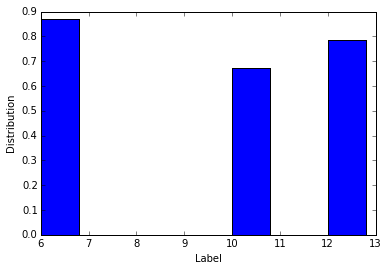

In [68]:
#columns = ["Steer_Angle", "Velocity", "Heading", "Brightness","Steer_Velocity", "Brake", "Pedal", "Fuel", "X_Accel", "Y_Accel", "Mileage", "RPM", "R_Sig"]
#superfd = LoadDataFrame('../dfall.pkl')
#ClassificationPipeline(loadfile=True,filename='../newclassificationdata.pkl',users=[4,10,12,13])
#ClassificationPipeline(superdf=superfd,filename='../newclassificationdata.pkl',users=[4,10,12,13],featurecolumns=columns)
data = LoadDataFrame('../classificationdata.pkl')
ClusteringPipeline(data[:,:-1],data[:,-1],[6,10,12])

6 done
10 done
45 done
35 done


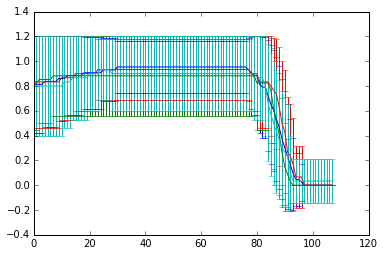

In [9]:
#superdf = pickle.load(open('../dfall.pkl'))
#plotComparison(superdf,'Y_Accel',['6','10'],[[(0,'2014-04-04'),(1,'2014-04-04'),(2,'2014-04-04'),(3,'2014-04-04')],[(0,'2014-04-29'),(1,'2014-04-29'),(2,'2014-04-29'),(3,'2014-04-29')]])
#plotUser(superdf,user='6',feature='Steer_Angle')
#plotFeature(superdf,users=['6','10','45','35'],feature='R_Sig',errorbar=True)